# 1. Introduction

## 1.1 Background Information

Singapore is centrally located in South East Asia, serving as a hub for major airlines connecting tourists to dream destinations such as Thailand, Malaysia, Indonesia, etc. As a results, many will stop over for a few days to discover the country who is known as a culinary and shopping haven.

After having our daughter, my husband and I have not stopped travelling but our needs for accomodations have changed. For instance, we would need a kitchen to prepare home-cooked food for our baby so Airbnb has become one of our top options for finding an accomodation. Hence, this project is to help travellers with kids to identify appropriate accomodations to fully enjoy their stay in Singapore.

## 1.2 Problem Statement

There are 4000+ over accomodations in the Airbnb lisiting as of December 2020. How can we classify these accomodations into clusters and find more easily the right accomodation that corresponds to the budget and preferences of the travellers? This project will try to answer this question.

## 1.3 Target Audience

This report is dedicated to travellers who are looking for a short period of stay in Singapore. The results should give them a quick overview of which areas to stay that would satisfy their budget and preferences. The type of accomodations has been limited to "Entire place" as these is the accomodation most suitable for family but it can be also be relevant for travellers who seek for such type of accomodation.


# 2. Data
## 2.1 Data Require

- Listing of Singapore AirBnb accomodation
- Number of venues including restaurants, shopping malls and tourists attractions in the vicinity of the accomodation's neighborhood

## 2.2 Data Sources

Below is the link to the dataset.

- Airbnb accommodation lisiting from Inside Airbnb: http://insideairbnb.com/get-the-data.html (Data compiled on December 2020)

- Foursquare API to extract data on venues in a neighbourhood: https://developer.foursquare.com/

## 2.3 Data Understanding and preparation

In [1]:
# import libraries
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip install folium
import folium

print('Libraires imported')

     |████████████████████████████████| 94 kB 3.3 MB/s eta 0:00:01
Libraires imported


In [2]:
#Fetch Singapore listing from AirBnB
df = pd.read_csv('http://data.insideairbnb.com/singapore/sg/singapore/2020-12-29/visualisations/listings.csv', low_memory = False)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,79,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,80,90,18,2014-12-26,0.22,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,66,6,20,2015-10-01,0.17,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,174,90,20,2020-01-17,0.18,8,365
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,93,90,24,2019-10-13,0.21,8,365


In [3]:
df.shape

(4387, 16)

In order to simplify the table, we keep only the essential columns necessary for this project

In [4]:
# Keep only essential columns
df1 = df[["id", "neighbourhood", "latitude", "longitude", "room_type", "price", "minimum_nights", "availability_365", "reviews_per_month", "number_of_reviews"]]
df1.head()

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,reviews_per_month,number_of_reviews
0,49091,Woodlands,1.44255,103.79580,Private room,79,180,365,0.01,1
1,50646,Bukit Timah,1.33235,103.78521,Private room,80,90,365,0.22,18
2,56334,Woodlands,1.44246,103.79667,Private room,66,6,365,0.17,20
3,71609,Tampines,1.34541,103.95712,Private room,174,90,365,0.18,20
4,71896,Tampines,1.34567,103.95963,Private room,93,90,365,0.21,24


We want to keep accomodations with the active hosts and hosts who accepts short term stays (ex: <7days) 

In [5]:
# Filter data to keep essential rows
df1 = df1[(df1.minimum_nights <= 7) # for short term stay
           & (df1.number_of_reviews >= 10) # active host
           & (~df1.room_type.isin(['Entire home/apt']) )
           & (df1.availability_365 >= 10)
          ]

df1 = df1.reset_index(drop = True)

df1.shape

(309, 10)

We check if all the rows are correctly filled and the types of data corresponds to the title of the column

In [6]:
df1.isnull().sum()

id                   0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
availability_365     0
reviews_per_month    0
number_of_reviews    0
dtype: int64

In [7]:
df1.dtypes

id                     int64
neighbourhood         object
latitude             float64
longitude            float64
room_type             object
price                  int64
minimum_nights         int64
availability_365       int64
reviews_per_month    float64
number_of_reviews      int64
dtype: object

We plot box plot to see the distribution of the prices and if there is a need to remove outliers

Text(0.5, 0.98, '')

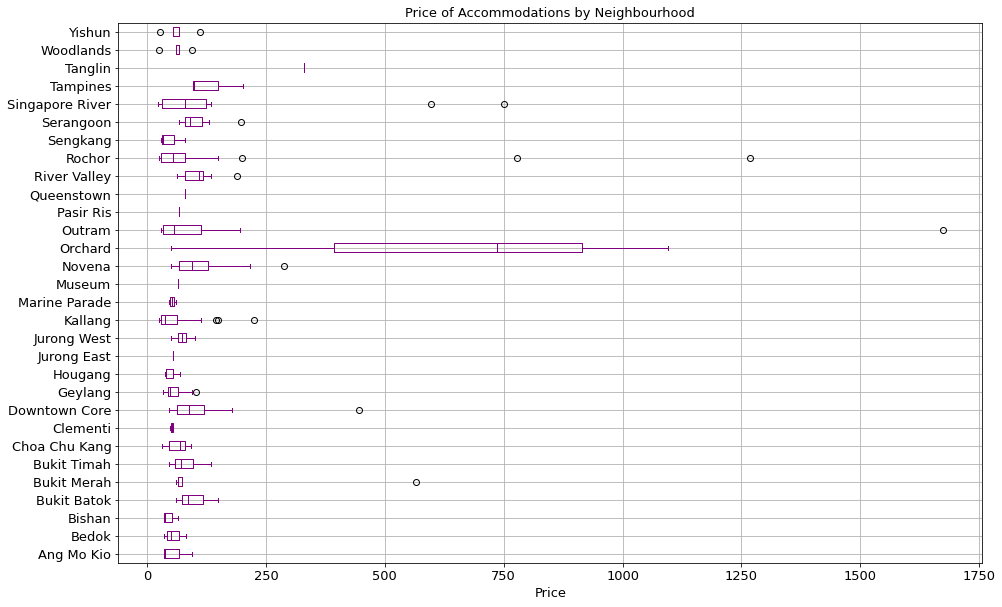

In [8]:
# Plot a box plot
box = df1[['neighbourhood','price']].boxplot(
    column='price', 
    by='neighbourhood',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

Since there are outliers, we will to remove them to make the clustering more efficient 

In [9]:
# Calculate Q1, Q3 and IQR
Q1 = df1.price.quantile(0.25)
Q3 = df1.price.quantile(0.75)
IQR = Q3 - Q1

# Remove data that is not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR)
condition = (df1.price >= Q1 - 1.5 * IQR) & (df1.price <= Q3 + 1.5 *IQR)
df1 = df1.loc[condition]  

df1.shape

(291, 10)

Text(0.5, 0.98, '')

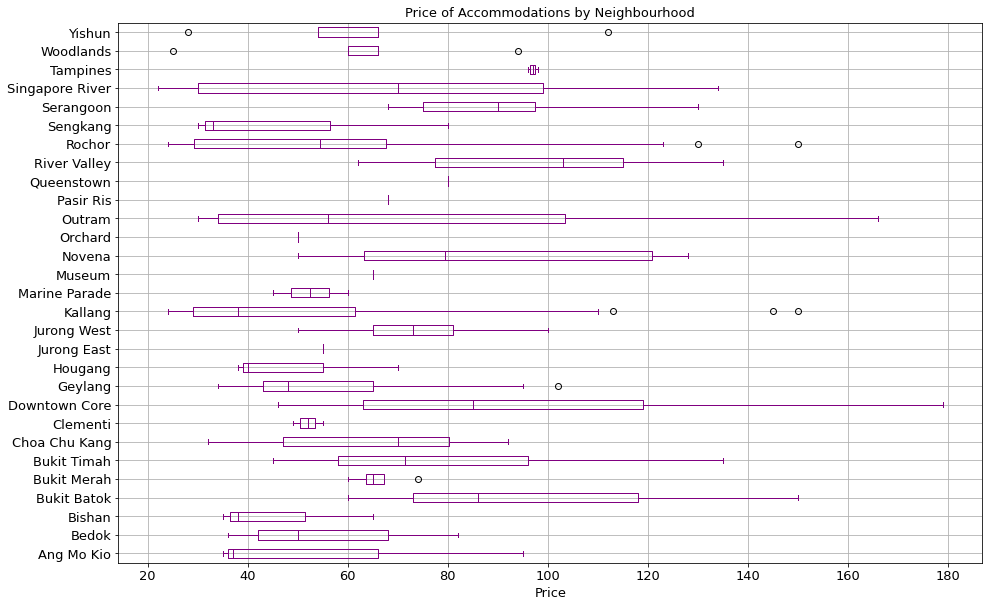

In [10]:
# Plot a box plot
box = df1[['neighbourhood','price']].boxplot(
    column='price', 
    by='neighbourhood',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

The distribution of the prices of the Airbnb's accomodation by neighbourhood is now ready for use in the further analysis